Credits to Elissaios Sarmas for the code, which was adapted for use on this dataset (credits to Xiaomin Chang). Code can be found here: https://github.com/ElissaiosSarmas/Transfer-learning-strategies-for-solar-power-forecasting-under-data-scarcity

In [2]:
# Clear any logs from previous runs
!rm -r ./LSTM_w_TL_2/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
import datetime, os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras_layer_normalization import LayerNormalization
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import Input,Model
from tensorflow.keras.models import load_model
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK, STATUS_FAIL, space_eval
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [4]:
path = "C:/work/Honours code/Datasets/PV-Output-Datasets-main/1 gazbray.csv"

p2 = pd.read_csv(path, header=0, sep= ';')

In [5]:
p2_copy = p2.copy()
p2_copy['Date'] = pd.to_datetime(p2['Date'], format='%d/%m/%Y')

# p2_copy.drop(['period_end'], axis=1, inplace=True)

# dropping columns that are not needed
# p2_copy.drop(['Unnamed: 0', 'period_x', 'period_y', '_id_x', '_id_y'], axis=1, inplace=True)

# make the date the first column
date = p2_copy.pop('Date')
p2_copy.insert(0, 'Date', date)

# extract the hour and month from the timestamp
# p2_copy['hour'] = pd.to_datetime(p2_copy['Date']).dt.hour
# p2_copy['month'] = pd.to_datetime(p2_copy['Date']).dt.month

# convert the Cond colmn to dummy variables
p2_copy['Cond'] = p2_copy['Cond'].astype('category').cat.codes

In [6]:
categories = p2['Cond'].astype('category').cat.categories
category_code_mapping = {code: category for code, category in enumerate(categories)}
print(category_code_mapping)

{0: 'Cloudy', 1: 'Fine', 2: 'Showers'}


In [7]:
p2_copy

,Date,Generated,Exported,subGen,mmGen,subExp,mmExp,Cond,Temp med
0,2015-07-01,14.5,11.0,2.3,15.65,1,11.5,0,15.5
1,2015-07-02,16.8,12.0,2.3,17.70,3,13.5,0,13.0
2,2015-07-03,18.6,15.0,1.8,18.40,-2,14.0,1,12.5
3,2015-07-04,18.2,13.0,-0.4,17.90,0,13.0,0,12.5
4,2015-07-05,17.6,13.0,-0.6,18.00,-1,12.5,0,13.5
...,...,...,...,...,...,...,...,...,...
1456,2019-06-26,5.7,2.0,-3.2,8.65,4,4.0,2,17.5
1457,2019-06-27,11.6,6.0,5.9,12.40,2,7.0,2,18.0
1458,2019-06-28,13.2,8.0,1.6,13.25,-1,7.5,0,17.0
1459,2019-06-29,13.3,7.0,0.1,14.00,0,7.0,0,16.5


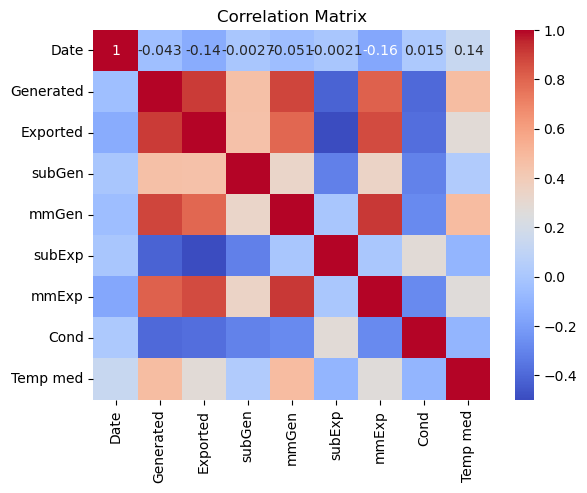

In [8]:
corr_matrix = p2_copy.corr()
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

I will need to drop one variable to match the features for the other datasets (10). Probably will drop Exported, as it seems to be highly correlated with Generated and seems less relevant than other variables.

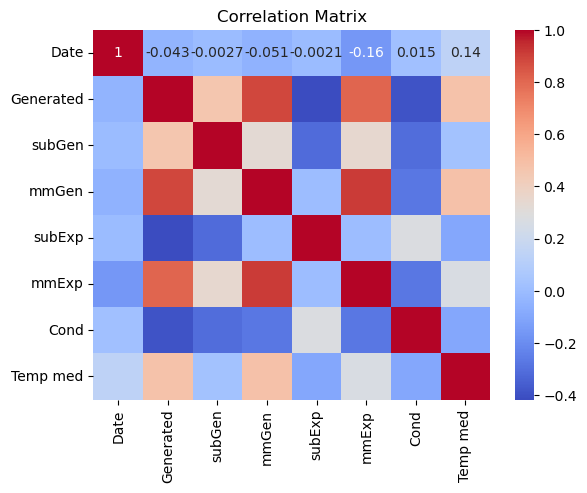

In [9]:
cols_to_keep = ['Date', 'Generated', 'subGen', 'mmGen', 'subExp', 'mmExp', 'Cond', 'Temp med']
corr_plot2 = p2_copy[cols_to_keep]
corr_mat2 = corr_plot2.corr()
# Plot the correlation matrix
sns.heatmap(corr_mat2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [10]:
p2_copy_2 = p2_copy.drop(['Exported'], axis=1)

In [11]:

# Perform One-Hot-Encoding for Months and Sin-Cos Similarities for Hours
data = p2_copy_2
data['Date'] = pd.to_numeric(data['Date'])
#data = pd.get_dummies(data, columns=['month'])
data.loc[:,'sin_hour'] = np.sin(2*np.pi*data['Date']/24)
data.loc[:,'cos_hour'] = np.cos(2*np.pi*data['Date']/24)

print("Total Entries =", len(data))

Total Entries = 1461


In [12]:
# Shaping data for LSTM input
def split_sequences(sequences, n_steps, n_outputs, only_production, validation_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + n_outputs > len(sequences):
            break
        # gather input and output parts of the pattern
        if only_production==True:
            seq_x, seq_y = sequences[i:end_ix, -1], sequences[end_ix:(end_ix+n_outputs), -1]
        else:
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:(end_ix+n_outputs), -1]
            
        X.append(seq_x)
        y.append(seq_y)
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [13]:
def unique_shapes(x, y, lag_, n_features_, num_of_outputs_, only_production, validation_split):
    unique_shapes = []
    for k in range(len(x)):
        if only_production==True:
            if (x[k].shape == (lag,)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)
        else:
            if (x[k].shape == (lag_, n_features_)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)       
    x = x[unique_shapes]
    y = y[unique_shapes]
    x = np.stack(x)
    y = np.stack(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [14]:
cols = data.columns.tolist()
cols

['Date',
 'Generated',
 'subGen',
 'mmGen',
 'subExp',
 'mmExp',
 'Cond',
 'Temp med',
 'sin_hour',
 'cos_hour']

In [15]:
# Select the columns that you want to use as features
cols = ['Date',
 'subGen',
 'mmGen',
 'subExp',
 'mmExp',
 'Cond',
 'Temp med',
 'sin_hour',
 'cos_hour',
 'Generated']

# Set to True if using only the production, else to False
only_production = False
# Splitting factor for training set and test set
split = 0.4

# Select the lag variable, the number of features (must be same with cols selected) and the horizon
lag = 5
n_features = len(cols)
num_of_outputs = 1

Padding the data to match the domain dataset

In [16]:
timesteps = 5
features = 10
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_array = data['Date'].values
# flatten the data
data_array = data_array.reshape(-1)
total_features = ((len(data_array) // (timesteps * features)) + 1) * (timesteps * features)
# calculate the padding
padding = total_features - len(data_array)
# pad the data
data_padded = np.pad(data_array, (0, padding), 'constant')

# Reshape the data
data_padded = data_padded.reshape(-1, timesteps, features)

print(data_padded.shape)

(30, 5, 10)


In [17]:
# x_train_flattened = x_train.reshape(-1)
# x_test_flattened = x_test.reshape(-1)
# # flatten then pad the data
# total_x_train_features = ((len(x_train_flattened) // (timesteps * features)) + 1) * (timesteps * features)
# total_x_test_features = ((len(x_test_flattened) // (timesteps * features)) + 1) * (timesteps * features)
# # calculate the padding
# padding_train = total_x_train_features - len(x_train_flattened)
# padding_test = total_x_test_features - len(x_test_flattened)
# # pad for x
# x_train_padded = np.pad(x_train_flattened, (0, padding_train), 'constant')
# x_test_padded = np.pad(x_test_flattened, (0, padding_test), 'constant')
# # reshape the data
# x_train = x_train_padded.reshape(-1, timesteps, features)
# x_test = x_test_padded.reshape(-1, timesteps, features)

# # padding for y
# from tensorflow.keras.preprocessing.sequence import pad_sequences


# y_train = pad_sequences(y_train.reshape(-1, 1), maxlen=len(x_train), padding='post', value=0).reshape(-1)
# y_test = pad_sequences(y_test.reshape(-1, 1), maxlen=len(x_test), padding='post', value=0).reshape(-1)
# # make sure the lengths are the same
# if len(y_train) > len(x_train):
#     y_train = y_train[:len(x_train)]
# if len(y_test) > len(x_test):
#     y_test = y_test[:len(x_test)]
# if len(y_train) < len(x_train):
#     length_diff = len(x_train) - len(y_train)
#     y_train = np.pad(y_train, (0, length_diff), 'constant', constant_values=0)
# if len(y_test) < len(x_test):
#     length_diff = len(x_test) - len(y_test)
#     y_test = np.pad(y_test, (0, length_diff), 'constant', constant_values=0)

# print("Adjusted Size of Train =", x_train.shape, y_train.shape)
# print("Adjusted Size of Test =", x_test.shape, y_test.shape)

In [18]:
# Scale data seperately
from sklearn.preprocessing import MinMaxScaler

if only_production == True:
    data_ = data_['SystemProduction']
    train = data_.iloc[:int(len(data_)*split_),]
    test = data_.iloc[int(len(data_)*split_):,]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1, 1))
    test = scaler.fit_transform(test.values.reshape(-1, 1))
else:
    # convert numpy array to pandas dataframe
    # data = pd.DataFrame(data_padded.reshape(-1, features))
    # flatten the data
    data = data_padded.reshape(-1, len(cols))
    print(data.shape)
    data = pd.DataFrame(data, columns=cols)
    data = data[cols]
    train = data.iloc[:int(len(data)*split),:]
    test = data.iloc[int(len(data)*split):,]
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)

(150, 10)


In [19]:
# Create the input for LSTM: x(batch_size, lag, features), y(batch_size,)

x_train, x_val, y_train, y_val = split_sequences(train, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = split_sequences(test, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)

x_train, x_val, y_train, y_val = unique_shapes(x_train, y_train, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = unique_shapes(x_test, y_test, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)


# Reshape for only_production case
if only_production:
    x_train = x_train.reshape((x_train.shape[0], lag, 1))
    x_test = x_test.reshape((x_test.shape[0], lag, 1))
else:
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
# Print the shapes
print("Size of Train / Test =", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Size of Train / Test = (19, 5, 10) (19, 1) (30, 5, 10) (30, 1)


Since the datasets are different, the shapes won't match up and cause issues. I will perform PCA to reduce the features so they match.

In [20]:
# # num_samples, timesteps, features = x_train.shape
# x_train_2d = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])
# x_test_2d = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2]) 

# pca = PCA(n_components=10)
# pca.fit(x_train_2d)

# x_train_pca = pca.fit_transform(x_train_2d)
# x_test_pca = pca.transform(x_test_2d)


# features = pca.n_components_
# features = 106
# x_train_pca_3d = x_train_pca.reshape(-1, timesteps, features)
# x_test_pca_3d = x_test_pca.reshape(-1,timesteps, features)

# print("Size of Train / Test =", x_train_pca_3d.shape, y_train.shape, x_test_pca_3d.shape, y_test.shape)

In [21]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))



base_model_path = "C:/work/Honours code/Transfer learning/LSTM/model/LSTM_base.h5"

def createModel():

    # BI-LSTM Model Architecture

    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    model = Model(inputs=model.inputs, outputs=output)
    #model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = model(inputs, training=False)
    # x = model(inputs, training=False)
    print("Input shape:", x_train.shape)
    x = Bidirectional(LSTM(16, activation="relu", return_sequences=False))(x)
    x = Dropout(0.27)(x)

    # x = Dense(500, activation="relu")(x)
    outputs  = Dense(1)(x)

    model = Model(inputs, outputs)

    # Compile model
    optimizer = Adam(learning_rate=0.00083)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model.summary()

    return model

In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from keras.layers import TFSMLayer
from tensorflow.keras import backend as K
import h5py
import os
import time
timestamp = int(time.time())
true_values = []
predicted_values = []
model_path = "LSTM_model_2.h5"
#model_path = "model/PV2_LSTM_base_v2.weights.tf"
#model_path = f"model/PV2_LSTM_base_v2_{timestamp}.weights.tf"
#model_path = f"model/PV2_LSTM_base_v2_{timestamp}.tf"
K.clear_session()
def fit_predict_stats(model):
    # Early stopping property
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    tb = TensorBoard(log_dir='logs')
    experiment_name = 'run_4'
    log_dir = f'./logs/{experiment_name}'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #history = model.fit(x_train, y_train, epochs=100, validation_split=0.15969857235280177, batch_size=32, verbose=1, shuffle=True, callbacks=[es]).history  
    #history = model.fit(x_train, y_train, epochs=100, validation_split=0.12, batch_size=32, verbose=1, shuffle=True, callbacks=[es,tb]).history
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    # Model fine-tuning
    model.trainable = True
    model.layers[0].trainable = True
    model.layers[1].trainable = True
    optimizer = Adam(learning_rate=0.0001) # Decreasing the learning rate to prevent overfitting
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    history = model.fit(x_train, y_train, epochs=20, validation_split=0.2, batch_size=128, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
    
    if os.path.exists(model_path):
        
    # Load the model
        tf.debugging.set_log_device_placement(True)
        model = load_model(model_path)
        #model = TFSMLayer(model_path, call_endpoint='serving_default')
        #model = tf.saved_model.load(model_path)
        #model = tf.keras.models.load_model(model_path)
        #model.load_weights(model_path)
        #os.remove(model_path)  # remove existing file
    else:
        # Model file does not exist, so save the model
        
        # Fit the model
        #model.save_weights(model_path)
        
        model.save(model_path, overwrite=True)
        #tf.saved_model.save(model, model_path)
        #model.save_weights(model_path)


    

    #Load the model
    #model = load_model(r'model/PV2_LSTM_base.tf')
    # with h5py.File('PV2_LSTM_base.tf', 'a') as file:
    #     if 'PV2_LSTM_base' in file:
    #         del file['PV2_LSTM_base']

    # summarize history for MAE and MSE
    # plt.plot(history['loss'])
    # plt.plot(history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('Model MSE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # plt.figure()
    # plt.plot(history['mae'])
    # plt.plot(history['val_mae'])
    # plt.title('Model MAE')
    # plt.ylabel('MAE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # Metrics on scaled data
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    y_pred = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    # print('Train Scaled RMSE: {}'.format(rmse))
    # print('Train Scaled MAE: {}'.format(mae))
    # print('Train Scaled R2 Score: ', r2_score(y_train, y_pred)*100)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # print('Test Scaled RMSE: {}'.format(rmse))
    # print('Test Scaled MAE: {}'.format(mae))
    # print('Test Scaled R2 Score: ',r2_score(y_test, y_pred)*100)


    
    # Metrics on original data
    true = []
    hat = []
    range_ = [0]
    # range_ = list(range(6))

    for i,j in zip([[x_train,y_train],[x_test,y_test]],['Train','Test']):
        # make a prediction
        yhat = model.predict(i[0])
        if yhat.shape == (yhat.shape[0],):
            yhat = yhat.reshape((yhat.shape[0],1))  
      
        y_hat = []
        for k in range(len(yhat)):
            if k == 0:
                for l in range_:
                    y_hat.append(yhat[k,l])
            else:
                y_hat.append(yhat[k,-1])
        
        y_hat = np.stack(y_hat)
        y_hat = y_hat.reshape((y_hat.shape[0],1))

        ### trying to resolve the issue of different shapes
        total_elements = np.product(i[0].shape)
        lag = i[0].shape[1]
        n_features = i[0].shape[2]
        print("Total elements in data:", total_elements)
        ###
        
        i[0] = i[0].reshape((i[0].shape[0],lag,n_features))
        
        x_hat = []
        for k in range(len(i[0])):
            if k == 0:
                x_hat.append(i[0][k])
            elif k!= 0:
                x_hat.append(i[0][k][-1,:])
        
        x_hat = np.vstack(x_hat)
        
        initial_x_hat_shape = x_hat.shape[0]
        initial_y_hat_shape = y_hat.shape[0]
        
        print(x_hat.shape)
        print(y_hat.shape)
        
        if x_hat.shape[0]-y_hat.shape[0] != 0.0:
            if x_hat.shape[0] > y_hat.shape[0]:
                for k in range(x_hat.shape[0]-y_hat.shape[0]):
                    y_hat = np.insert(y_hat, 0, y_hat[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_hat.shape[0]:
                y_hat = y_hat[-int(x_hat.shape[0]-y_hat.shape[0]):,:]
                added_values = False
        
        print(x_hat[:,:-1].shape)
        print(y_hat.shape)
        
        # invert scaling for forecast
        if only_production==True:
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
        else:    
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            
        # invert scaling for actual
        y_true = []
        for k in range(len(i[1])):
            if k ==0:
                for l in range_:
                    y_true.append(i[1][k,l])
            else:
                y_true.append(i[1][k,-1])

        y_true = np.stack(y_true)
        y_true = y_true.reshape((y_true.shape[0],1))
        print(y_true.shape)

        initial_y_true_shape = y_true.shape[0]
        
        if x_hat.shape[0]-y_true.shape[0] != 0.0:
            if x_hat.shape[0] > y_true.shape[0]:
                for k in range(x_hat.shape[0]-y_true.shape[0]):
                    y_true = np.insert(y_true, 0, y_true[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_true.shape[0]:
                y_true = y_true[-int(x_hat.shape[0]-y_true.shape[0]):,:]
                added_values = False
                
        if only_production==True:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
        else:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,-1]
        
        true.append(inv_y)
        hat.append(inv_yhat)

        # true_values.append(true)
        # predicted_values.append(hat)
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate MAE
        mae = mean_absolute_error(inv_y, inv_yhat)
        print('Test MAE: %.3f' % mae)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print('Test R2 Score: ',r2)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        print('MAPE', mape)
        # Calculate MBE
        mbe = np.mean(inv_yhat - inv_y)
        print('Test MBE', mbe)
        # Calculate nRMSE
        nRMSE = rmse / np.mean(inv_y)
        print('nRMSE', nRMSE)

        



    mae_list.append(mae)
    rmse_list.append(rmse)
    r_square_list.append(r2)
    mape_list.append(mape)
    mbe_list.append(mbe)
    nRMSE_list.append(nRMSE)



In [23]:
mae_list = []
rmse_list = []
r_square_list = []
mape_list = []
mbe_list = []
nRMSE_list = []
num_iterations = 20
#num_iterations = 2
for i in range(num_iterations):
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)
    model = createModel()
    keras.config.disable_traceback_filtering()
    fit_predict_stats(model)

# sns.set_style("darkgrid")
# for true, hat in zip(true_values, predicted_values):
#     plt.figure()
#     plt.plot(true[1], color="green")
#     plt.plot(hat[1], color="red")
#     plt.savefig('plots/lstm_base_plot.png')
    #plt.show()

print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("R^2:", r_square_list)
print("MAPE:", mape_list)
print("MBE:", mbe_list)
print("nRMSE:", nRMSE_list)

print("Mean MAE:", np.mean(mae_list))
print("Mean RMSE:", np.mean(rmse_list))
print("Mean R^2:", np.mean(r_square_list))
print("Mean MAPE:", np.mean(mape_list))
print("Mean MBE:", np.mean(mbe_list))
print("Mean nRMSE:", np.mean(nRMSE_list))


Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.3132 - mae: 0.5100 - val_loss: 0.3866 - val_mae: 0.5488
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2787 - mae: 0.4782 - val_loss: 0.3611 - val_mae: 0.5304
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.2432 - mae: 0.4542 - val_loss: 0.3352 - val_mae: 0.5110
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2272 - mae: 0.4388 - val_loss: 0.3094 - val_mae: 0.4909
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2264 - mae: 0.4317 - val_loss: 0.2813 - val_mae: 0.4683
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1987 - mae: 0.4094 - val_loss: 0.2495 - val_mae: 0.4414
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2069 - mae: 0.4071 - val_loss: 0.2174 - val_mae: 0.4125
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1366 - mae: 0.3455 - val_loss: 0.1837 - val_mae: 0.3799
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1174 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_17 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.2720 - mae: 0.4779 - val_loss: 0.3659 - val_mae: 0.5343
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2549 - mae: 0.4629 - val_loss: 0.3286 - val_mae: 0.5067
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.2258 - mae: 0.4336 - val_loss: 0.2917 - val_mae: 0.4780
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2205 - mae: 0.4256 - val_loss: 0.2573 - val_mae: 0.4495
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1996 - mae: 0.4041 - val_loss: 0.2235 - val_mae: 0.4195
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1311 - mae: 0.3392 - val_loss: 0.1888 - val_mae: 0.3863
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1297 - mae: 0.3329 - val_loss: 0.1524 - val_mae: 0.3481
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0992 - mae: 0.2886 - val_loss: 0.1165 - val_mae: 0.3057
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0938

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_27 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.3037 - mae: 0.4975 - val_loss: 0.3896 - val_mae: 0.5506
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2805 - mae: 0.4837 - val_loss: 0.3566 - val_mae: 0.5267
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2379 - mae: 0.4499 - val_loss: 0.3234 - val_mae: 0.5017
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2223 - mae: 0.4292 - val_loss: 0.2907 - val_mae: 0.4760
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1889 - mae: 0.4006 - val_loss: 0.2574 - val_mae: 0.4483
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1870 - mae: 0.3952 - val_loss: 0.2240 - val_mae: 0.4187
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1497 - mae: 0.3565 - val_loss: 0.1902 - val_mae: 0.3866
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.1432 - mae: 0.3406 - val_loss: 0.1569 - val_mae: 0.3520
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1156

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_37 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.3166 - mae: 0.5181 - val_loss: 0.3949 - val_mae: 0.5555
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2757 - mae: 0.4807 - val_loss: 0.3533 - val_mae: 0.5259
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2245 - mae: 0.4417 - val_loss: 0.3130 - val_mae: 0.4955
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2252 - mae: 0.4371 - val_loss: 0.2704 - val_mae: 0.4615
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2364 - mae: 0.4327 - val_loss: 0.2294 - val_mae: 0.4261
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1740 - mae: 0.3808 - val_loss: 0.1903 - val_mae: 0.3892
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.1294 - mae: 0.3385 - val_loss: 0.1521 - val_mae: 0.3492
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1104 - mae: 0.3048 - val_loss: 0.1157 - val_mae: 0.3061
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0945

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_47 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.2313 - mae: 0.4373 - val_loss: 0.2969 - val_mae: 0.4821
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1735 - mae: 0.3841 - val_loss: 0.2500 - val_mae: 0.4433
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 0.1955 - mae: 0.4001 - val_loss: 0.2065 - val_mae: 0.4037
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.1245 - mae: 0.3315 - val_loss: 0.1635 - val_mae: 0.3605
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.1178 - mae: 0.3114 - val_loss: 0.1223 - val_mae: 0.3133
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0790 - mae: 0.2621 - val_loss: 0.0863 - val_mae: 0.2647
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0871 - mae: 0.2729 - val_loss: 0.0541 - val_mae: 0.2113
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0578 - mae: 0.2204 - val_loss: 0.0280 - val_mae: 0.1533
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0529

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_57 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.3477 - mae: 0.5391 - val_loss: 0.4525 - val_mae: 0.5927
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.3104 - mae: 0.5085 - val_loss: 0.4043 - val_mae: 0.5607
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2828 - mae: 0.4823 - val_loss: 0.3596 - val_mae: 0.5292
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2283 - mae: 0.4381 - val_loss: 0.3169 - val_mae: 0.4974
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2279 - mae: 0.4374 - val_loss: 0.2761 - val_mae: 0.4648
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2167 - mae: 0.4192 - val_loss: 0.2374 - val_mae: 0.4317
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1362 - mae: 0.3445 - val_loss: 0.1986 - val_mae: 0.3957
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1630 - mae: 0.3690 - val_loss: 0.1604 - val_mae: 0.3568
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0933

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Total elements in data: 1500
(34, 10)
(30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_67 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.3446 - mae: 0.5254 - val_loss: 0.4043 - val_mae: 0.5604
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2535 - mae: 0.4660 - val_loss: 0.3512 - val_mae: 0.5228
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2287 - mae: 0.4383 - val_loss: 0.3014 - val_mae: 0.4850
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1762 - mae: 0.3913 - val_loss: 0.2556 - val_mae: 0.4474
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1757 - mae: 0.3870 - val_loss: 0.2128 - val_mae: 0.4090
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1309 - mae: 0.3422 - val_loss: 0.1736 - val_mae: 0.3702
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1136 - mae: 0.3088 - val_loss: 0.1379 - val_mae: 0.3309
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0746 - mae: 0.2592 - val_loss: 0.1038 - val_mae: 0.2882
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0886

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_77 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.2580 - mae: 0.4620 - val_loss: 0.3142 - val_mae: 0.4965
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2614 - mae: 0.4632 - val_loss: 0.2769 - val_mae: 0.4669
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2033 - mae: 0.4155 - val_loss: 0.2435 - val_mae: 0.4387
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1966 - mae: 0.4035 - val_loss: 0.2121 - val_mae: 0.4103
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1521 - mae: 0.3619 - val_loss: 0.1818 - val_mae: 0.3809
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1339 - mae: 0.3384 - val_loss: 0.1524 - val_mae: 0.3499
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0976 - mae: 0.2933 - val_loss: 0.1230 - val_mae: 0.3158
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1223 - mae: 0.3153 - val_loss: 0.0949 - val_mae: 0.2788
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1025

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_87 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.2211 - mae: 0.4221 - val_loss: 0.2488 - val_mae: 0.4432
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1494 - mae: 0.3612 - val_loss: 0.2066 - val_mae: 0.4047
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1571 - mae: 0.3583 - val_loss: 0.1675 - val_mae: 0.3655
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0996 - mae: 0.2983 - val_loss: 0.1321 - val_mae: 0.3253
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0948 - mae: 0.2820 - val_loss: 0.0964 - val_mae: 0.2793
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0761 - mae: 0.2340 - val_loss: 0.0636 - val_mae: 0.2283
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0678 - mae: 0.2338 - val_loss: 0.0350 - val_mae: 0.1709
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0342 - mae: 0.1706 - val_loss: 0.0153 - val_mae: 0.1124
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0307

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_97 (Functional)      │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 32)             │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.3498 - mae: 0.5375 - val_loss: 0.4465 - val_mae: 0.5886
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3025 - mae: 0.5016 - val_loss: 0.4146 - val_mae: 0.5674
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2799 - mae: 0.4841 - val_loss: 0.3838 - val_mae: 0.5460
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2602 - mae: 0.4691 - val_loss: 0.3537 - val_mae: 0.5241
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2290 - mae: 0.4396 - val_loss: 0.3228 - val_mae: 0.5009
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2200 - mae: 0.4274 - val_loss: 0.2917 - val_mae: 0.4765
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2047 - mae: 0.4127 - val_loss: 0.2617 - val_mae: 0.4517
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1905 - mae: 0.3920 - val_loss: 0.2314 - val_mae: 0.4250
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.1457

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_107 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.3240 - mae: 0.5096 - val_loss: 0.4131 - val_mae: 0.5656
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2631 - mae: 0.4720 - val_loss: 0.3651 - val_mae: 0.5320
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2393 - mae: 0.4461 - val_loss: 0.3198 - val_mae: 0.4982
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2230 - mae: 0.4303 - val_loss: 0.2779 - val_mae: 0.4647
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2000 - mae: 0.4070 - val_loss: 0.2382 - val_mae: 0.4308
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.1728 - mae: 0.3781 - val_loss: 0.2004 - val_mae: 0.3957
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1366 - mae: 0.3368 - val_loss: 0.1650 - val_mae: 0.3597
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1348 - mae: 0.3240 - val_loss: 0.1311 - val_mae: 0.3213
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0935

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_117 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.2380 - mae: 0.4496 - val_loss: 0.3383 - val_mae: 0.5135
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2231 - mae: 0.4310 - val_loss: 0.3046 - val_mae: 0.4875
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2059 - mae: 0.4082 - val_loss: 0.2687 - val_mae: 0.4582
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1906 - mae: 0.3922 - val_loss: 0.2306 - val_mae: 0.4249
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1334 - mae: 0.3385 - val_loss: 0.1885 - val_mae: 0.3850
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1191 - mae: 0.3201 - val_loss: 0.1460 - val_mae: 0.3399
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0809 - mae: 0.2561 - val_loss: 0.1048 - val_mae: 0.2894
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0963 - mae: 0.2743 - val_loss: 0.0674 - val_mae: 0.2337
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.0560

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_127 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - loss: 0.3020 - mae: 0.5034 - val_loss: 0.3718 - val_mae: 0.5381
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2948 - mae: 0.4914 - val_loss: 0.3378 - val_mae: 0.5133
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2421 - mae: 0.4521 - val_loss: 0.3081 - val_mae: 0.4904
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2320 - mae: 0.4360 - val_loss: 0.2811 - val_mae: 0.4683
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2147 - mae: 0.4227 - val_loss: 0.2534 - val_mae: 0.4447
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1839 - mae: 0.3953 - val_loss: 0.2238 - val_mae: 0.4182
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1559 - mae: 0.3655 - val_loss: 0.1940 - val_mae: 0.3899
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1690 - mae: 0.3690 - val_loss: 0.1646 - val_mae: 0.3597
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1294

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_137 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - loss: 0.3247 - mae: 0.5229 - val_loss: 0.3733 - val_mae: 0.5410
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2964 - mae: 0.4902 - val_loss: 0.3256 - val_mae: 0.5058
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2117 - mae: 0.4278 - val_loss: 0.2840 - val_mae: 0.4728
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.1991 - mae: 0.4090 - val_loss: 0.2447 - val_mae: 0.4396
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1918 - mae: 0.4040 - val_loss: 0.2075 - val_mae: 0.4056
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1425 - mae: 0.3467 - val_loss: 0.1718 - val_mae: 0.3701
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0960 - mae: 0.2877 - val_loss: 0.1374 - val_mae: 0.3321
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0626 - mae: 0.2329 - val_loss: 0.1037 - val_mae: 0.2900
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0921

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_147 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.3350 - mae: 0.5274 - val_loss: 0.4342 - val_mae: 0.5801
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.3255 - mae: 0.5180 - val_loss: 0.3911 - val_mae: 0.5507
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2907 - mae: 0.4939 - val_loss: 0.3522 - val_mae: 0.5229
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2411 - mae: 0.4531 - val_loss: 0.3152 - val_mae: 0.4950
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2554 - mae: 0.4568 - val_loss: 0.2814 - val_mae: 0.4679
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2131 - mae: 0.4217 - val_loss: 0.2509 - val_mae: 0.4420
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1811 - mae: 0.3869 - val_loss: 0.2213 - val_mae: 0.4155
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1542 - mae: 0.3603 - val_loss: 0.1913 - val_mae: 0.3868
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1236

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_157 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 0.2405 - mae: 0.4557 - val_loss: 0.3357 - val_mae: 0.5128
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2377 - mae: 0.4438 - val_loss: 0.2888 - val_mae: 0.4766
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.2161 - mae: 0.4262 - val_loss: 0.2437 - val_mae: 0.4390
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1889 - mae: 0.3911 - val_loss: 0.2017 - val_mae: 0.4006
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1472 - mae: 0.3518 - val_loss: 0.1623 - val_mae: 0.3606
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1300 - mae: 0.3323 - val_loss: 0.1224 - val_mae: 0.3149
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0887 - mae: 0.2678 - val_loss: 0.0853 - val_mae: 0.2648
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0587 - mae: 0.2273 - val_loss: 0.0541 - val_mae: 0.2127
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0766

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_167 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.3198 - mae: 0.5135 - val_loss: 0.4013 - val_mae: 0.5595
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2877 - mae: 0.4856 - val_loss: 0.3704 - val_mae: 0.5375
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.2465 - mae: 0.4574 - val_loss: 0.3407 - val_mae: 0.5156
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.2482 - mae: 0.4535 - val_loss: 0.3117 - val_mae: 0.4933
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2162 - mae: 0.4246 - val_loss: 0.2818 - val_mae: 0.4692
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1764 - mae: 0.3885 - val_loss: 0.2529 - val_mae: 0.4446
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1786 - mae: 0.3873 - val_loss: 0.2239 - val_mae: 0.4184
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1527 - mae: 0.3638 - val_loss: 0.1923 - val_mae: 0.3881
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1346

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_177 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - loss: 0.3317 - mae: 0.5231 - val_loss: 0.4099 - val_mae: 0.5642
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2983 - mae: 0.4968 - val_loss: 0.3717 - val_mae: 0.5375
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2618 - mae: 0.4695 - val_loss: 0.3340 - val_mae: 0.5103
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2361 - mae: 0.4466 - val_loss: 0.2992 - val_mae: 0.4838
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2253 - mae: 0.4298 - val_loss: 0.2682 - val_mae: 0.4587
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2021 - mae: 0.4067 - val_loss: 0.2380 - val_mae: 0.4329
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2224 - mae: 0.4256 - val_loss: 0.2081 - val_mae: 0.4056
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1670 - mae: 0.3737 - val_loss: 0.1781 - val_mae: 0.3760
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1356

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Input shape: (19, 5, 10)


Model: "functional_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_187 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.2862 - mae: 0.4901 - val_loss: 0.3607 - val_mae: 0.5304
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2633 - mae: 0.4629 - val_loss: 0.3216 - val_mae: 0.5009
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2118 - mae: 0.4228 - val_loss: 0.2834 - val_mae: 0.4705
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2109 - mae: 0.4146 - val_loss: 0.2449 - val_mae: 0.4377
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1726 - mae: 0.3787 - val_loss: 0.2046 - val_mae: 0.4007
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1541 - mae: 0.3479 - val_loss: 0.1637 - val_mae: 0.3591
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1195 - mae: 0.3153 - val_loss: 0.1241 - val_mae: 0.3135
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0873 - mae: 0.2662 - val_loss: 0.0864 - val_mae: 0.2626
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0614

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
Shape of x_train: (19, 5, 10)
Shape of y_train: (19, 1)
Shape of x_test: (30, 5, 10)
Shape of y_test: (30, 1)


Input shape: (19, 5, 10)


Model: "functional_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_197 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.4266 - mae: 0.5830 - val_loss: 0.5047 - val_mae: 0.6233
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.3601 - mae: 0.5444 - val_loss: 0.4562 - val_mae: 0.5931
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3249 - mae: 0.5186 - val_loss: 0.4135 - val_mae: 0.5651
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2998 - mae: 0.4972 - val_loss: 0.3735 - val_mae: 0.5376
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2717 - mae: 0.4717 - val_loss: 0.3358 - val_mae: 0.5101
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2347 - mae: 0.4448 - val_loss: 0.2999 - val_mae: 0.4826
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2084 - mae: 0.4164 - val_loss: 0.2698 - val_mae: 0.4578
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1996 - mae: 0.4045 - val_loss: 0.2410 - val_mae: 0.4329
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1696

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Total elements in data: 950
(23, 10)
(19, 1)
(23, 9)
(23, 1)
(19, 1)
Test RMSE: 134659319141692032.000
Test MAE: 81321452733194688.000
Test R2 Score:  0.865150678845216
MAPE 0.09387019646323941
Test MBE 1.5798519307919898e+16
nRMSE 0.15789994503119947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Total elements in data: 1500
(34, 10)
(30, 1)
(34, 9)
(34, 1)
(30, 1)
Test RMSE: 714888889193063296.000
Test MAE: 658303801353331456.000
Test R2 Score:  -2.9824383424370278
MAPE 0.43636913217222106
Test MBE 6.583038013533315e+17
nRMSE 0.49972647149420135
MAE: [6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315e+17, 6.583038013533315

C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)
C:\Users\Sysadmin\AppData\Local\Temp\ipykernel_4500\1354866337.py:16: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fit_predict_stats(model)


In [1]:
#!rm -rf "c:/work/Honours code/Transfer learning/LSTM/logs/"
#!rm -r "c:/work/Honours code/Transfer learning/LSTM/logs/"
%load_ext tensorboard
#%tensorboard --logdir LSTM/logs/
%tensorboard --logdir  "c:/work/Honours code/Transfer learning/LSTM_w_TL_2/logs/run_4/"
#%tensorboard --logdir  "./LSTM/logs/"

%reload_ext tensorboard

Reusing TensorBoard on port 6011 (pid 8072), started 12:45:36 ago. (Use '!kill 8072' to kill it.)

In [25]:
%reload_ext tensorboard
#!kill 10060

# Hyperparameter tuning

Code adapted from Xiaomin Chang

In [26]:
base_model_path = "C:/work/Honours code/Transfer learning/LSTM/model/LSTM_base.h5"

def lstm_training(params):
    # initial_learning_rate = params['learning_rate']
    # fine_tuning_learning_rate = params['fine_tuning_learning_rate']
    new_lstm_units = params['new_lstm_units']
    # batch_size = params['batch_size']
    new_layer_dropout = params['new_layer_dropout']
    initial_validation_split = params['initial_validation_split']
    fine_tuning_validation_split = params['fine_tuning_validation_split']
  
    # create the model
    # Load Base model
    if os.path.exists(base_model_path):
        model = load_model(base_model_path)
    else:
        print("Base model not found")
        
    model.layers[0].trainable = False
    model.layers[1].trainable = False

    # Remove the last 2 layers
    # model.pop()
    # model.pop()
    output = model.layers[-3].output  # Retaining up to the third last layer
    model = Model(inputs=model.inputs, outputs=output)
    # model = Model(inputs=model.inputs)
    
    inputs = Input(shape=(x_train.shape[1:]))
    x = model(inputs, training=False)
    # x = model(inputs, training=False)
    # print("Input shape:", x_train.shape)

    x = Bidirectional(LSTM(new_lstm_units, activation="relu", return_sequences=False))(x)
    x = Dropout(new_layer_dropout)(x)
    # x = Dense(500, activation="relu")(x)

    outputs  = Dense(1)(x)

    model = Model(inputs, outputs)

    initial_lr = 0.01

    lr_schedule = ExponentialDecay(
        initial_lr,
        decay_steps=10000,
        decay_rate=0.96,
        staircase=True)

    # Compile model
    optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)
    # optimizer = Adam(learning_rate=initial_learning_rate, clipvalue=0.5)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model.summary()

    # return model

    try:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[es])

        # Model fine-tuning
        model.trainable = True
        model.layers[0].trainable = True
        model.layers[1].trainable = True
        # optimizer = Adam(learning_rate=fine_tuning_learning_rate) 
        # optimizer = Adam(learning_rate=0.0001) # Decreasing the learning rate to prevent overfitting
        optimizer = Adam(learning_rate=lr_schedule)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
        history = model.fit(x_train, y_train, epochs=20, validation_split=fine_tuning_validation_split, batch_size=128, verbose=1, shuffle=True, callbacks=[es]).history

        print(history) 
    
        #loss = history.history['val_loss'][-1]
        loss = np.min(history['val_loss'])
        return {'loss': loss, 'status': STATUS_OK}
    except Exception as e:
        print("Error: {}".format(e))
        print("Params: {}".format(params))
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [27]:
param_grid = {
    #'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    #'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    # 'batch_size': hp.choice('batch_size', [32, 64, 128, 256]), 
    'new_lstm_units': hp.choice('new_lstm_units', [16, 32, 64]),
    # 'lstm_units_2': hp.choice('lstm_units_2', [32, 64, 128]),
    # 'lstm_units_3': hp.choice('lstm_units_3', [64, 128, 256]), 
    'new_layer_dropout': hp.uniform('new_layer_dropout', 0.1, 0.5),
    'initial_validation_split': hp.uniform('validation_split', 0.1, 0.2),
    'fine_tuning_validation_split': hp.uniform('fine_tuning_validation_split', 0.1, 0.2)
    # 'layer1_dropout': hp.uniform('layer1_dropout', 0.1, 0.5),
    # 'layer2_dropout': hp.uniform('layer2_dropout', 0.1, 0.5)
}

In [28]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=20)
best = fmin(lstm_training, param_grid, algo=algo, max_evals=100, pass_expr_memo_ctrl=None, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Model: "functional_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_207 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 0.2977 - mae: 0.4844
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.2977 - mae: 0.4844 - val_loss: 1.1900 - val_mae: 1.0903

Epoch 1/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 0.1272 - mae: 0.2911
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.1272 - mae: 0.2911 - val_loss: 0.3424 - val_mae: 0.5066

Epoch 2/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 0.2147 - mae: 0.4252
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step - loss: 0.2147 - mae: 0.4252 - val_loss: 0.4103 - val_mae: 0.5520

Epoch 3/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2397 - mae: 0.4489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2397 - mae: 0.4489 - val_loss: 0.4043 - val_mae: 0.5450

Epoch 4/20                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2451 - mae: 0.4502
1/1 ━━━━━━━━━━━━

Model: "functional_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_217 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 0.2729 - mae: 0.4753
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.2729 - mae: 0.4753 - val_loss: 0.0681 - val_mae: 0.2604

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0472 - mae: 0.1335
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 0.0472 - mae: 0.1335 - val_loss: 0.1774 - val_mae: 0.3559

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.0961 - mae: 0.2842
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0961 - mae: 0.2842 - val_loss: 0.0643 - val_mae: 0.2116

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0452 - mae: 0.1762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0452 - mae: 0.1762 - val_loss: 0.0361 - val_mae: 0.1794

Epoch 4/20                                           

Model: "functional_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_227 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.3194 - mae: 0.5056
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.3194 - mae: 0.5056 - val_loss: 0.0701 - val_mae: 0.2643

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0236 - mae: 0.1067
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.0236 - mae: 0.1067 - val_loss: 0.2032 - val_mae: 0.3827

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - loss: 0.1403 - mae: 0.3303
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step - loss: 0.1403 - mae: 0.3303 - val_loss: 0.0568 - val_mae: 0.2010

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0474 - mae: 0.1639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0474 - mae: 0.1639 - val_loss: 0.1690 - val_mae: 0.3739

Epoch 4/20                                        

Model: "functional_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_237 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.3713 - mae: 0.5460
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.3713 - mae: 0.5460 - val_loss: 0.0381 - val_mae: 0.1951

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.0550 - mae: 0.2080
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.0550 - mae: 0.2080 - val_loss: 8.4797 - val_mae: 2.3793

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4271 - mae: 0.9162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.4271 - mae: 0.9162 - val_loss: 0.0096 - val_mae: 0.0746

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0328 - mae: 0.1424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0328 - mae: 0.1424 - val_loss: 0.1590 - val_mae: 0.3436

Epoch 4/20                                          

Model: "functional_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_247 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - loss: 0.3632 - mae: 0.5354
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - loss: 0.3632 - mae: 0.5354 - val_loss: 0.0018 - val_mae: 0.0419

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0213 - mae: 0.1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.0213 - mae: 0.1000 - val_loss: 13.4185 - val_mae: 2.9094

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 5.2711 - mae: 1.7894
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 5.2711 - mae: 1.7894 - val_loss: 0.0568 - val_mae: 0.1857

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.1449 - mae: 0.1863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.1449 - mae: 0.1863 - val_loss: 0.1218 - val_mae: 0.3089

Epoch 4/20                                      

Model: "functional_259"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_257 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.2685 - mae: 0.4683
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.2685 - mae: 0.4683 - val_loss: 0.1733 - val_mae: 0.4156

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.0168 - mae: 0.1033
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.0168 - mae: 0.1033 - val_loss: 0.0294 - val_mae: 0.1526

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0350 - mae: 0.1358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0350 - mae: 0.1358 - val_loss: 0.3637 - val_mae: 0.5387

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2719 - mae: 0.4338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2719 - mae: 0.4338 - val_loss: 0.0133 - val_mae: 0.1119

Epoch 4/20                                        

Model: "functional_269"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_267 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.3323 - mae: 0.5199
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.3323 - mae: 0.5199 - val_loss: 0.5430 - val_mae: 0.7364

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - loss: 0.0736 - mae: 0.1917
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - loss: 0.0736 - mae: 0.1917 - val_loss: 0.3797 - val_mae: 0.5320

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.2225 - mae: 0.4358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.2225 - mae: 0.4358 - val_loss: 0.3980 - val_mae: 0.5422

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2417 - mae: 0.4475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2417 - mae: 0.4475 - val_loss: 0.3732 - val_mae: 0.5200

Epoch 4/20                                         

Model: "functional_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_277 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.2893 - mae: 0.4871
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 0.2893 - mae: 0.4871 - val_loss: 0.4300 - val_mae: 0.6553

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0592 - mae: 0.1708
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 0.0592 - mae: 0.1708 - val_loss: 0.3470 - val_mae: 0.5082

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2326 - mae: 0.4378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2326 - mae: 0.4378 - val_loss: 0.3475 - val_mae: 0.5046

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2095 - mae: 0.4196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2095 - mae: 0.4196 - val_loss: 0.2801 - val_mae: 0.4466

Epoch 4/20                                         

Model: "functional_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_287 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.2921 - mae: 0.4912
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.2921 - mae: 0.4912 - val_loss: 0.0303 - val_mae: 0.1738

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0424 - mae: 0.1736
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.0424 - mae: 0.1736 - val_loss: 1.3890 - val_mae: 0.9291

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - loss: 0.7374 - mae: 0.5958
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - loss: 0.7374 - mae: 0.5958 - val_loss: 0.0152 - val_mae: 0.1097

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0415 - mae: 0.1567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0415 - mae: 0.1567 - val_loss: 0.1546 - val_mae: 0.3448

Epoch 4/20                                         

Model: "functional_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_297 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.2771 - mae: 0.4752
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.2771 - mae: 0.4752 - val_loss: 1.2680 - val_mae: 1.1253

Epoch 1/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - loss: 0.1490 - mae: 0.2509
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - loss: 0.1490 - mae: 0.2509 - val_loss: 0.3290 - val_mae: 0.4959

Epoch 2/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1992 - mae: 0.4116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1992 - mae: 0.4116 - val_loss: 0.3807 - val_mae: 0.5307

Epoch 3/20                                                                           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2344 - mae: 0.4421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2344 - mae: 0.4421 - val_loss: 0.3675 - val_mae: 0.5167

Epoch 4/20                                         

Model: "functional_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_307 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.2248 - mae: 0.4316
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.2248 - mae: 0.4316 - val_loss: 0.4035 - val_mae: 0.6346

Epoch 1/20                                                                            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.3597 - mae: 0.3036
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.3597 - mae: 0.3036 - val_loss: 0.2534 - val_mae: 0.4465

Epoch 2/20                                                                            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 0.1722 - mae: 0.3875
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - loss: 0.1722 - mae: 0.3875 - val_loss: 0.3352 - val_mae: 0.5103

Epoch 3/20                                                                            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2201 - mae: 0.4300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2201 - mae: 0.4300 - val_loss: 0.3419 - val_mae: 0.5125

Epoch 4/20                                     

Model: "functional_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_317 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.2447 - mae: 0.4439
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.2447 - mae: 0.4439 - val_loss: 0.5049 - val_mae: 0.7099

Epoch 1/20                                                                            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.1102 - mae: 0.2057
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - loss: 0.1102 - mae: 0.2057 - val_loss: 0.2725 - val_mae: 0.4620

Epoch 2/20                                                                            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1948 - mae: 0.4026
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1948 - mae: 0.4026 - val_loss: 0.3054 - val_mae: 0.4853

Epoch 3/20                                                                            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2077 - mae: 0.4073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - loss: 0.2077 - mae: 0.4073 - val_loss: 0.2583 - val_mae: 0.4414

Epoch 4/20                                          

Model: "functional_329"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_327 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - loss: 0.4888 - mae: 0.6250
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.4888 - mae: 0.6250 - val_loss: 0.3652 - val_mae: 0.6043

Epoch 1/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - loss: 0.1664 - mae: 0.3572
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 0.1664 - mae: 0.3572 - val_loss: 0.3183 - val_mae: 0.4356

Epoch 2/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 0.3395 - mae: 0.2453
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - loss: 0.3395 - mae: 0.2453 - val_loss: 0.0558 - val_mae: 0.2052

Epoch 3/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0380 - mae: 0.1641
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0380 - mae: 0.1641 - val_loss: 0.1423 - val_mae: 0.3225

Epoch 4/20                                  

Model: "functional_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_337 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 64)             │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,689 (1.08 MB)

 Trainable params: 271,681 (1.04 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.3554 - mae: 0.5356
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.3554 - mae: 0.5356 - val_loss: 0.0058 - val_mae: 0.0756

Epoch 1/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - loss: 0.0223 - mae: 0.1171
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.0223 - mae: 0.1171 - val_loss: 0.0435 - val_mae: 0.1870

Epoch 2/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - loss: 0.0436 - mae: 0.1478
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step - loss: 0.0436 - mae: 0.1478 - val_loss: 0.2951 - val_mae: 0.4981

Epoch 3/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.5519 - mae: 0.5236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.5519 - mae: 0.5236 - val_loss: 0.0323 - val_mae: 0.1703

Epoch 4/20                                 

Model: "functional_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_347 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_34                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,121 (1.42 MB)

 Trainable params: 362,113 (1.38 MB)

 Non-trainable params: 11,008 (43.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.3971 - mae: 0.5666
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.3971 - mae: 0.5666 - val_loss: 0.0587 - val_mae: 0.2420

Epoch 1/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - loss: 0.0071 - mae: 0.0690
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 0.0071 - mae: 0.0690 - val_loss: 0.2927 - val_mae: 0.4481

Epoch 2/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1599 - mae: 0.3567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 0.1599 - mae: 0.3567 - val_loss: 0.0583 - val_mae: 0.2168

Epoch 3/20                                                                             

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0222 - mae: 0.1227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0222 - mae: 0.1227 - val_loss: 0.5630 - val_mae: 0.6802

Epoch 4/20                                 

Model: "functional_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 5, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_357 (Functional)     │ (None, 5, 256)         │       208,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ (None, 32)             │        34,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,617 (951.63 KB)

 Trainable params: 232,609 (908.63 KB)

 Non-trainable params: 11,008 (43.00 KB)

In [ ]:
best_hps = space_eval(param_grid, best)
print(best_hps)

{'fine_tuning_validation_split': 0.10498717302624735, 'initial_validation_split': 0.17358521320998577, 'new_layer_dropout': 0.36153517168335964, 'new_lstm_units': 32}
